In [22]:
import matplotlib.pyplot as plt;
import seaborn as sns

plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import pandas as pd
import numpy as np

import arviz as az
import pymc as pm
import pytensor.tensor as pt

In [3]:
# Global variables
GREY_COLOUR = '#B4B4B3'
RED_COLOUR0 = '#F78CA2'
RED_COLOUR1 = '#E8466A'
RED_COLOUR2 = '#D80032'



In [4]:
data = pd.read_csv("../data/clean-ifood-data.csv")
data.head()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,Z_Revenue,Response,Age,Customer_Days,MntTotal,MntRegularProds,AcceptedCmpOverall,marital,education,YearsAsCustomer
0,58138.0,0,0,58,635,88,546,172,88,88,...,11,1,63,2822,1529,1441,0,Single,Graduation,8
1,46344.0,1,1,38,11,1,6,2,1,6,...,11,0,66,2272,21,15,0,Single,Graduation,6
2,71613.0,0,0,26,426,49,127,111,21,42,...,11,0,55,2471,734,692,0,Together,Graduation,7
3,26646.0,1,0,26,11,4,20,10,3,5,...,11,0,36,2298,48,43,0,Together,Graduation,6
4,58293.0,1,0,94,173,43,118,46,27,15,...,11,0,39,2320,407,392,0,Married,PhD,6


/home/drmhlelebe/anaconda3/envs/pymc-env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/drmhlelebe/anaconda3/envs/pymc-env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


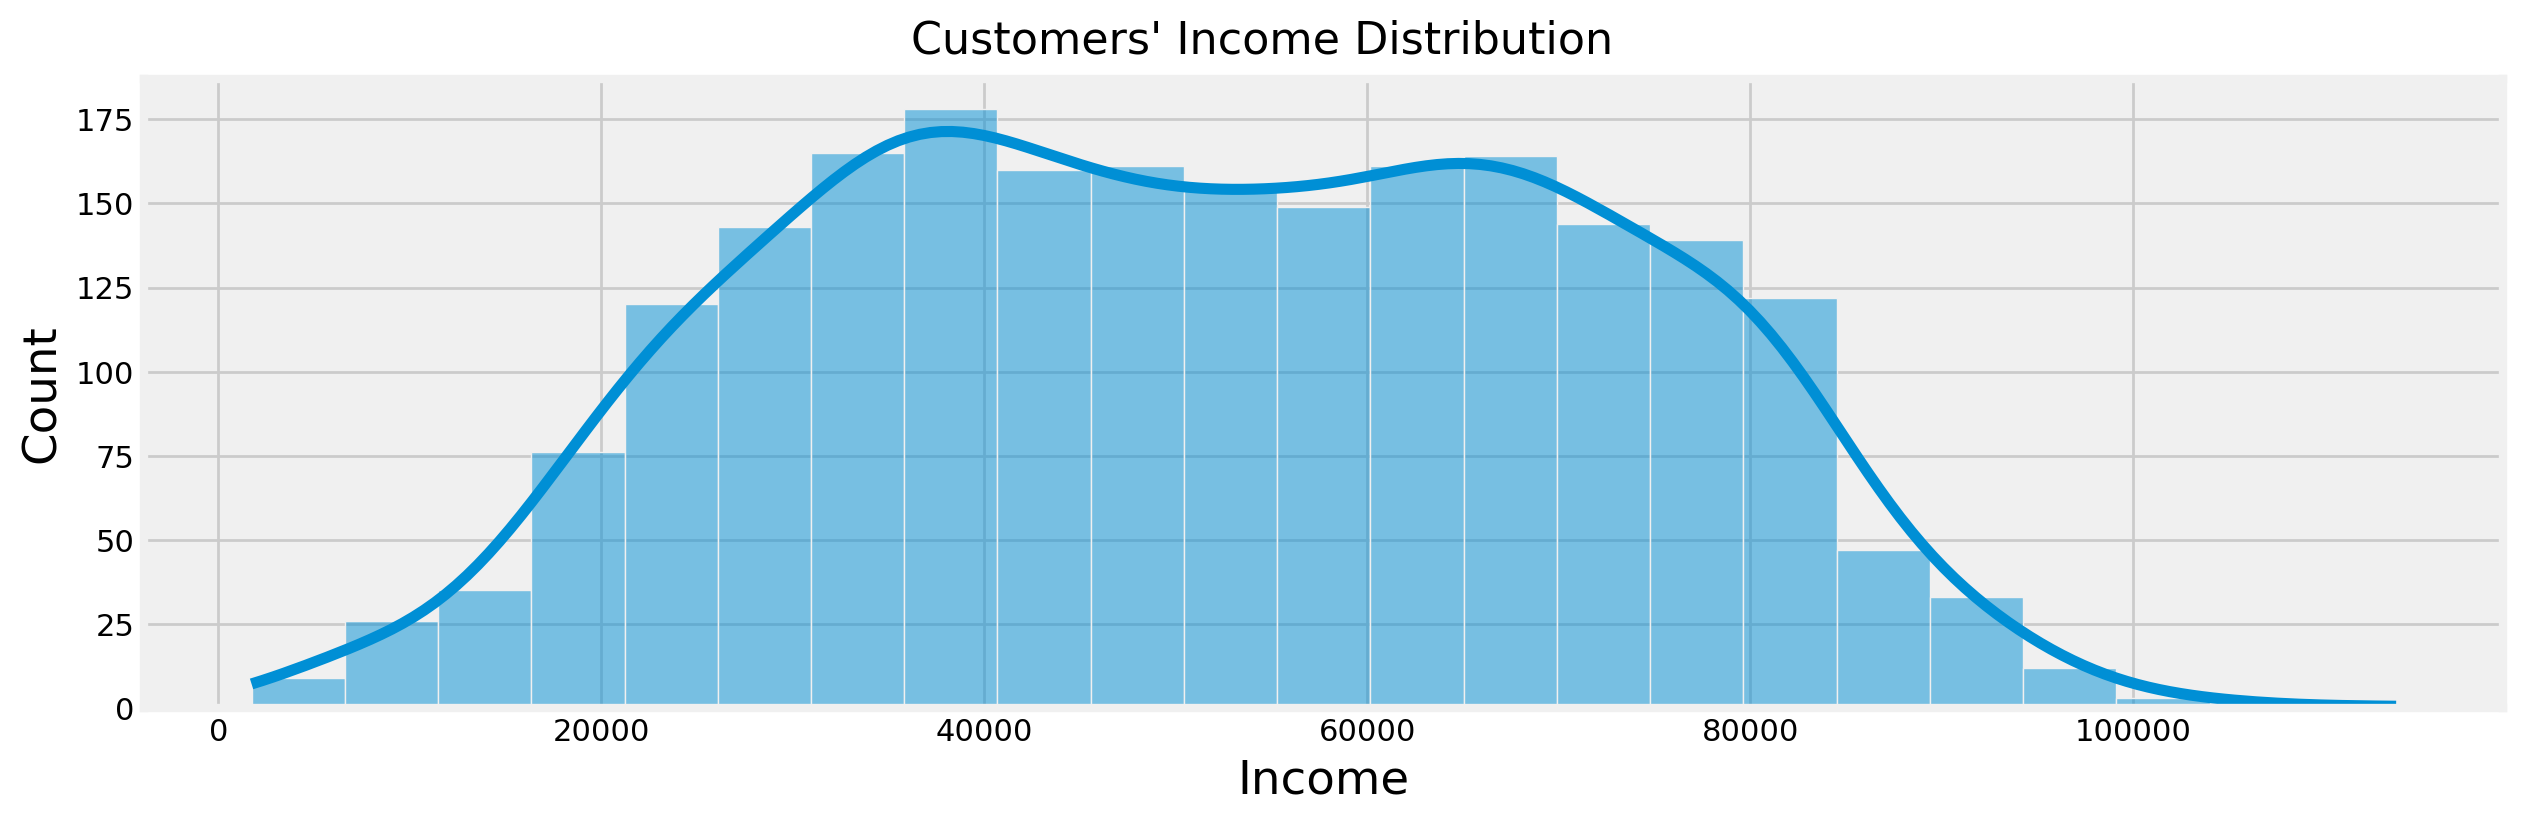

In [23]:
fig, ax = plt.subplots(figsize=(12.5, 4), layout="constrained")
_ = sns.histplot(x="Income", kde=True, data=data, ax=ax)
_ = fig.suptitle("Customers' Income Distribution", fontsize=16)

## Categorizing Customers By Income

First time I saw this distribution, I developed a feeling that our dataset might just have two types of earners. I am therefore going to follow-through with this idea and write a mixture model that can either confirm or deny this idea.

### Model Specification
The - seemingly - bimodal nature of this distribution makes me think that perhaps we have two types of customers as far as their incomes are concerned. To that end, I think it's more practical that these two types come from oppositely skewed Normal distributions like the Kappa logo. \
To be more concrete, I think I'm going to have two `Skew-Normal Distributions` which has 3 parameters $\mu$, $\tau$ and $\alpha$, so I'll assume the following as my priors:
$$\pmb{\mu} \sim \mathcal{N}([4000, 7000], 1000)$$
$$\pmb{\tau} = \frac{1}{\pmb{\sigma^{2}}}, \text{where } \sigma \sim \mathcal{U}(1, 1000)$$
$$\alpha_{1} \sim \mathcal{U}(0, 100), \alpha_{2} \sim \mathcal{U}(-100, 0)$$
So the likelihood will be:
$$\text{likelihood} \sim \mathcal{SN}(\pmb{\mu}, \pmb{\tau}, \pmb{\alpha})$$

In [6]:
sub_groups_num = 2
with pm.Model() as income_mixture_model:
    weights = pm.Dirichlet('weights', a=np.array([1, 1]), shape=sub_groups_num)
    μ = pm.Normal('μ', mu=np.array([40_000.0, 70_000.0]), sigma=10_000, shape=sub_groups_num)

    # defining τ without syntactic sugar. Don't know how to make it succinct
    sigma1 = pm.Uniform('sigma1', 1, 10_000)
    sigma2 = pm.Uniform('sigma2', 1, 10_000)
    tau1 = 1 / sigma1**2
    tau2 = 1 / sigma2**2
    tau = pm.math.stack([tau1, tau2])

    alpha1 = pm.Uniform('alpha1', -100, 100)
    alpha2 = pm.Uniform('alpha2', -100, 100)
    alpha = pm.math.stack([alpha1, alpha2])

    income_components = pm.SkewNormal.dist(alpha=alpha, mu=μ, tau=tau)

    likelihood = pm.Mixture('likelihood', w=weights, comp_dists=income_components, observed=data['Income'])

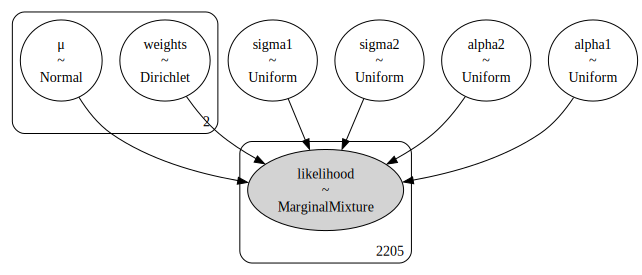

In [7]:
pm.model_to_graphviz(income_mixture_model)

### Prior & Posterior Predictive Checking

In [8]:
rng = np.random.default_rng(42)
with income_mixture_model:
    income_trace = pm.sample(random_seed=rng)
    # prior_pred_samples = pm.sample_prior_predictive()
    # posterior_pred_samples = pm.sample_posterior_predictive(trace=income_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, μ, sigma1, sigma2, alpha1, alpha2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 143 seconds.


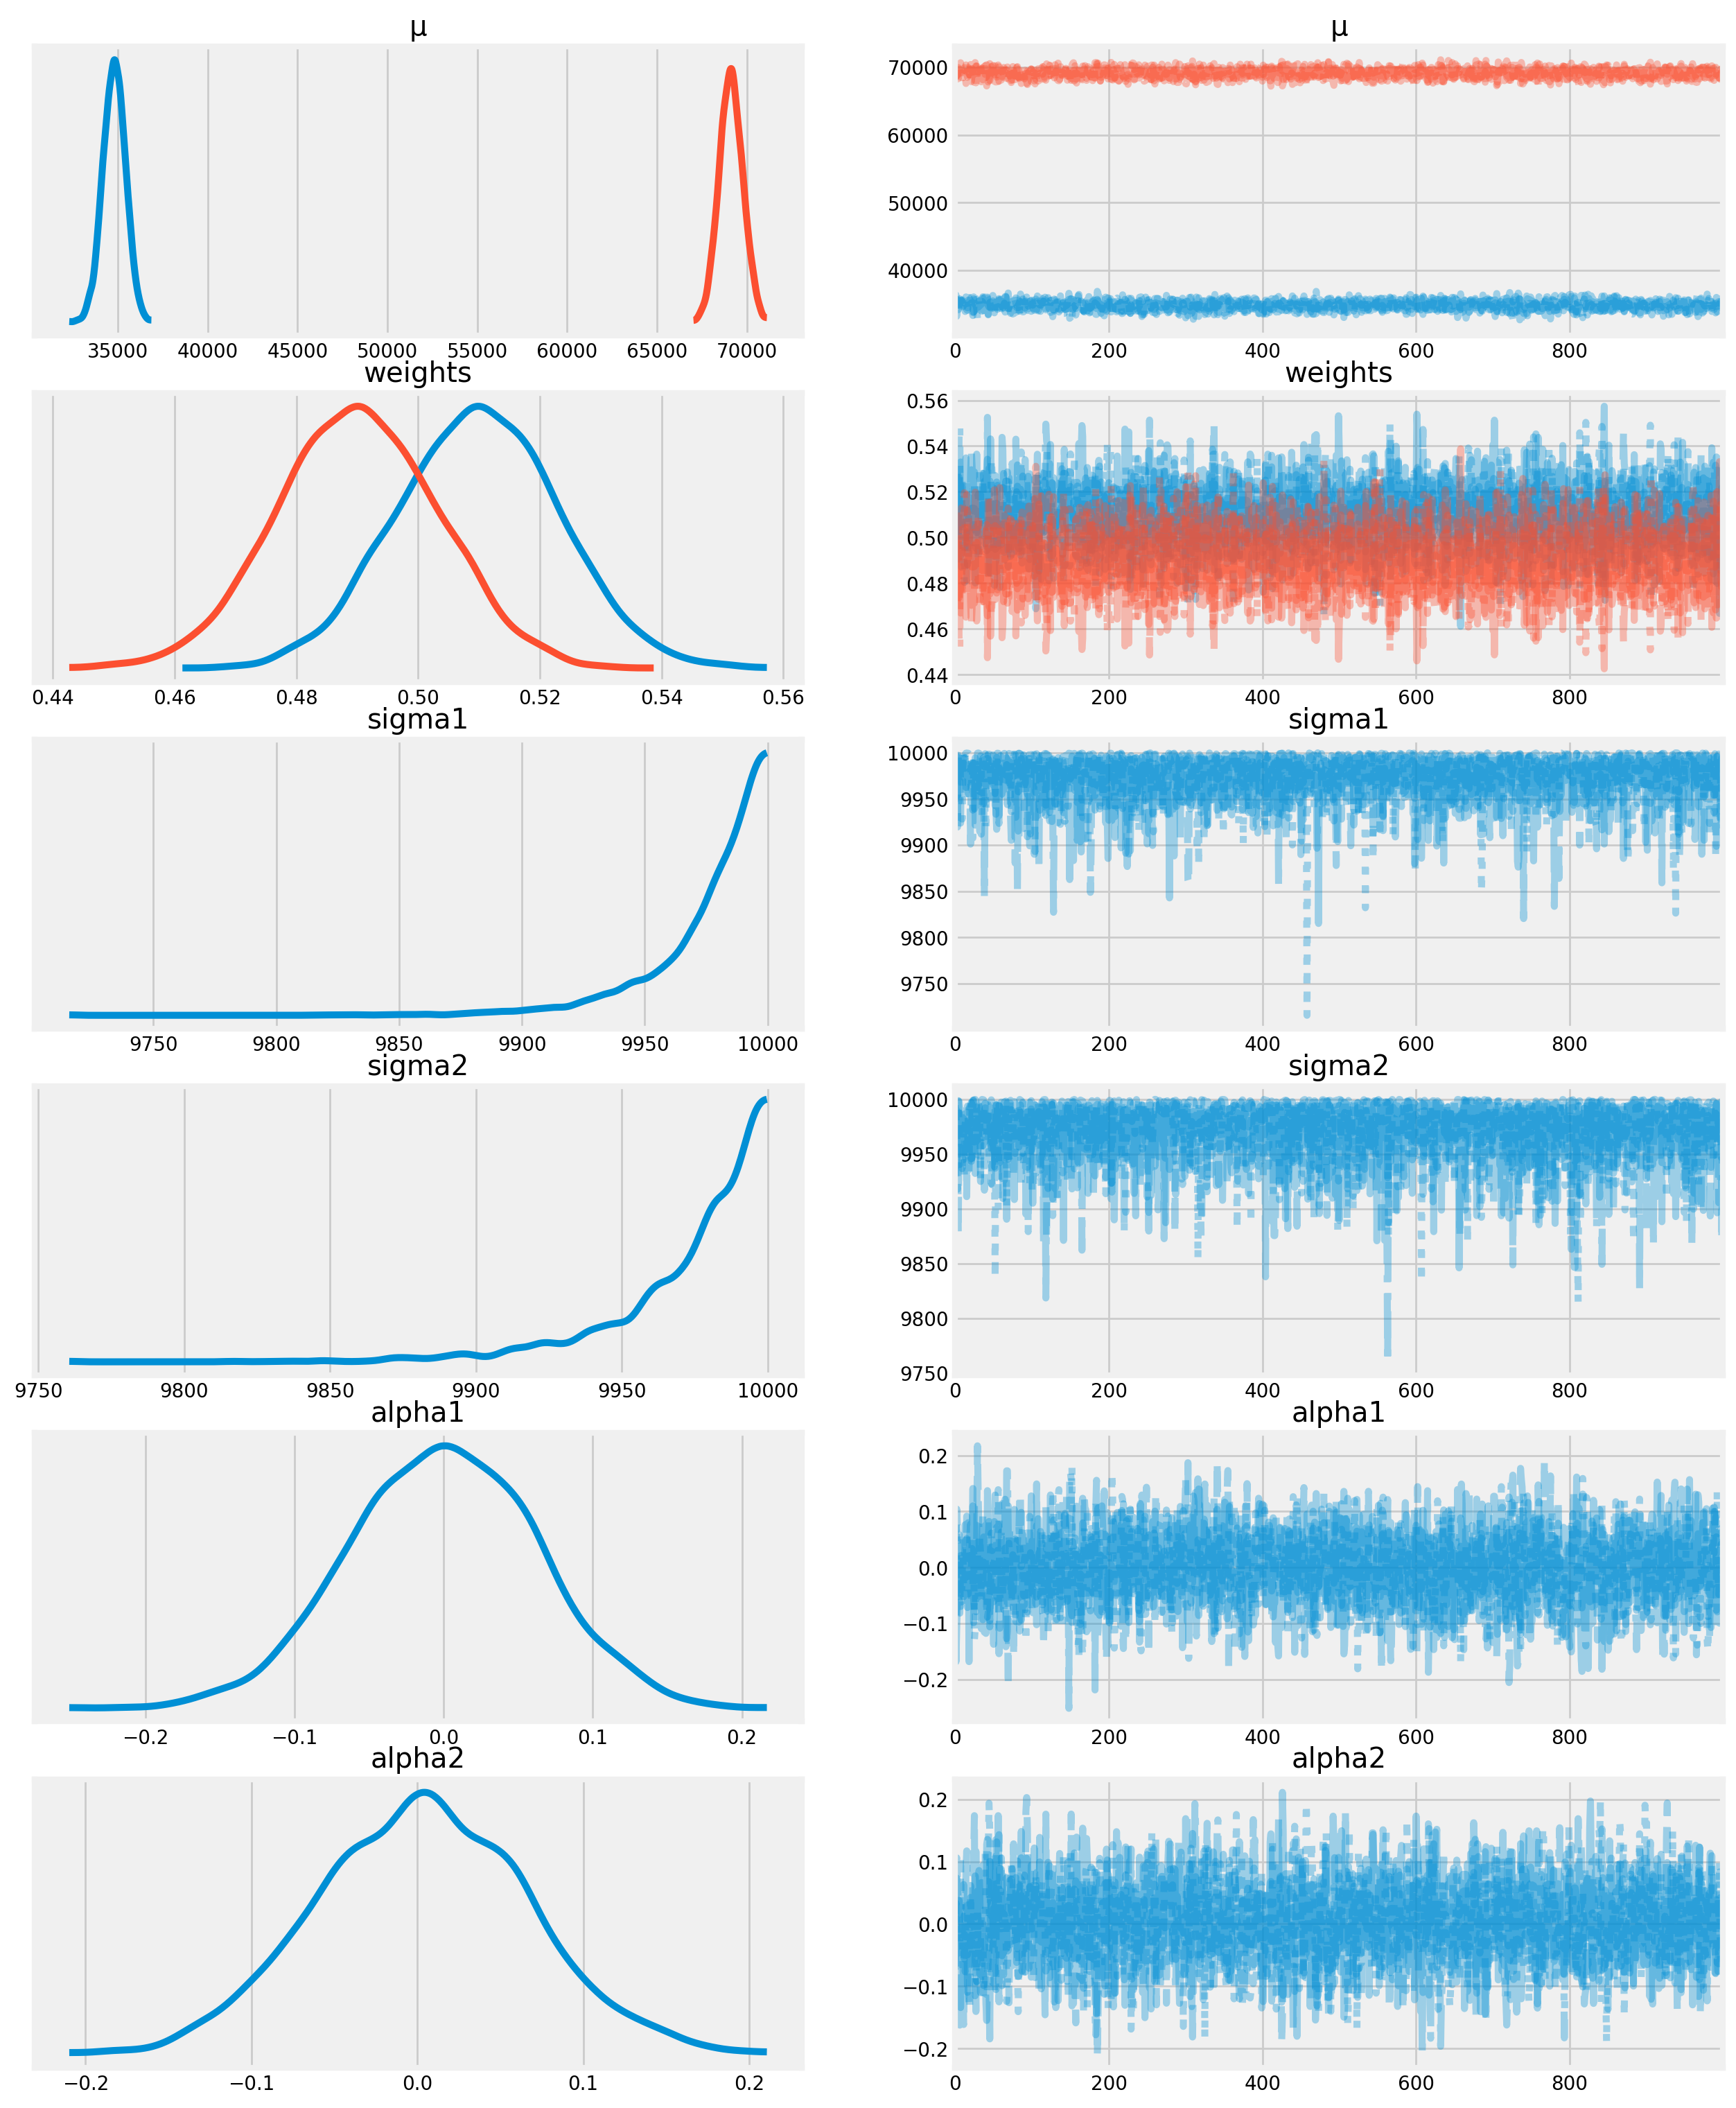

In [24]:
_ = az.plot_trace(income_trace, kind='trace', figsize=(14, 18), combined=True)

### Predictive Analysis

It looks like the results above are trying to correct my assumptions. First of all, there's little variability in the data than I had anticipated because now the model shows the variance of 1. Furthermore, both values of $\alpha$ seem to meet at 0, meaning my assumption of a Skew-Normal distribution may have been inaccurate, suggesting that a `Gaussian Mixture Model` might just be more appropriate. So let's try the following:
$$\pmb{\mu} \sim \mathcal{N}([35000, 70000], 10000)$$
$$\sigma \sim \mathcal{N}(10000, 1000)$$
$$\text{likelihood} \sim \mathcal{N}(\pmb{\mu}, \sigma)$$
In retrospect, this is even simpler and I should've started with it. I hate dissapointing Ockham and his razors :(

In [13]:
with pm.Model() as income_gaussian_mm:
    μ = pm.Normal(
        "μ",
        mu=data['Income'].mean(),
        sigma=10_000,
        shape=sub_groups_num,
        transform=pm.distributions.transforms.ordered,
        initval=[35_000, 70_000],
    )
    σ = pm.HalfNormal("σ", sigma=10_000, shape=sub_groups_num)
    weights = pm.Dirichlet("weights", np.ones(sub_groups_num))

    likelihood = pm.NormalMixture("likelihood", w=weights, mu=μ, sigma=σ, observed=data['Income'])

In [14]:
with income_gaussian_mm:
  income_gauss_trace = pm.sample(random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ, weights]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


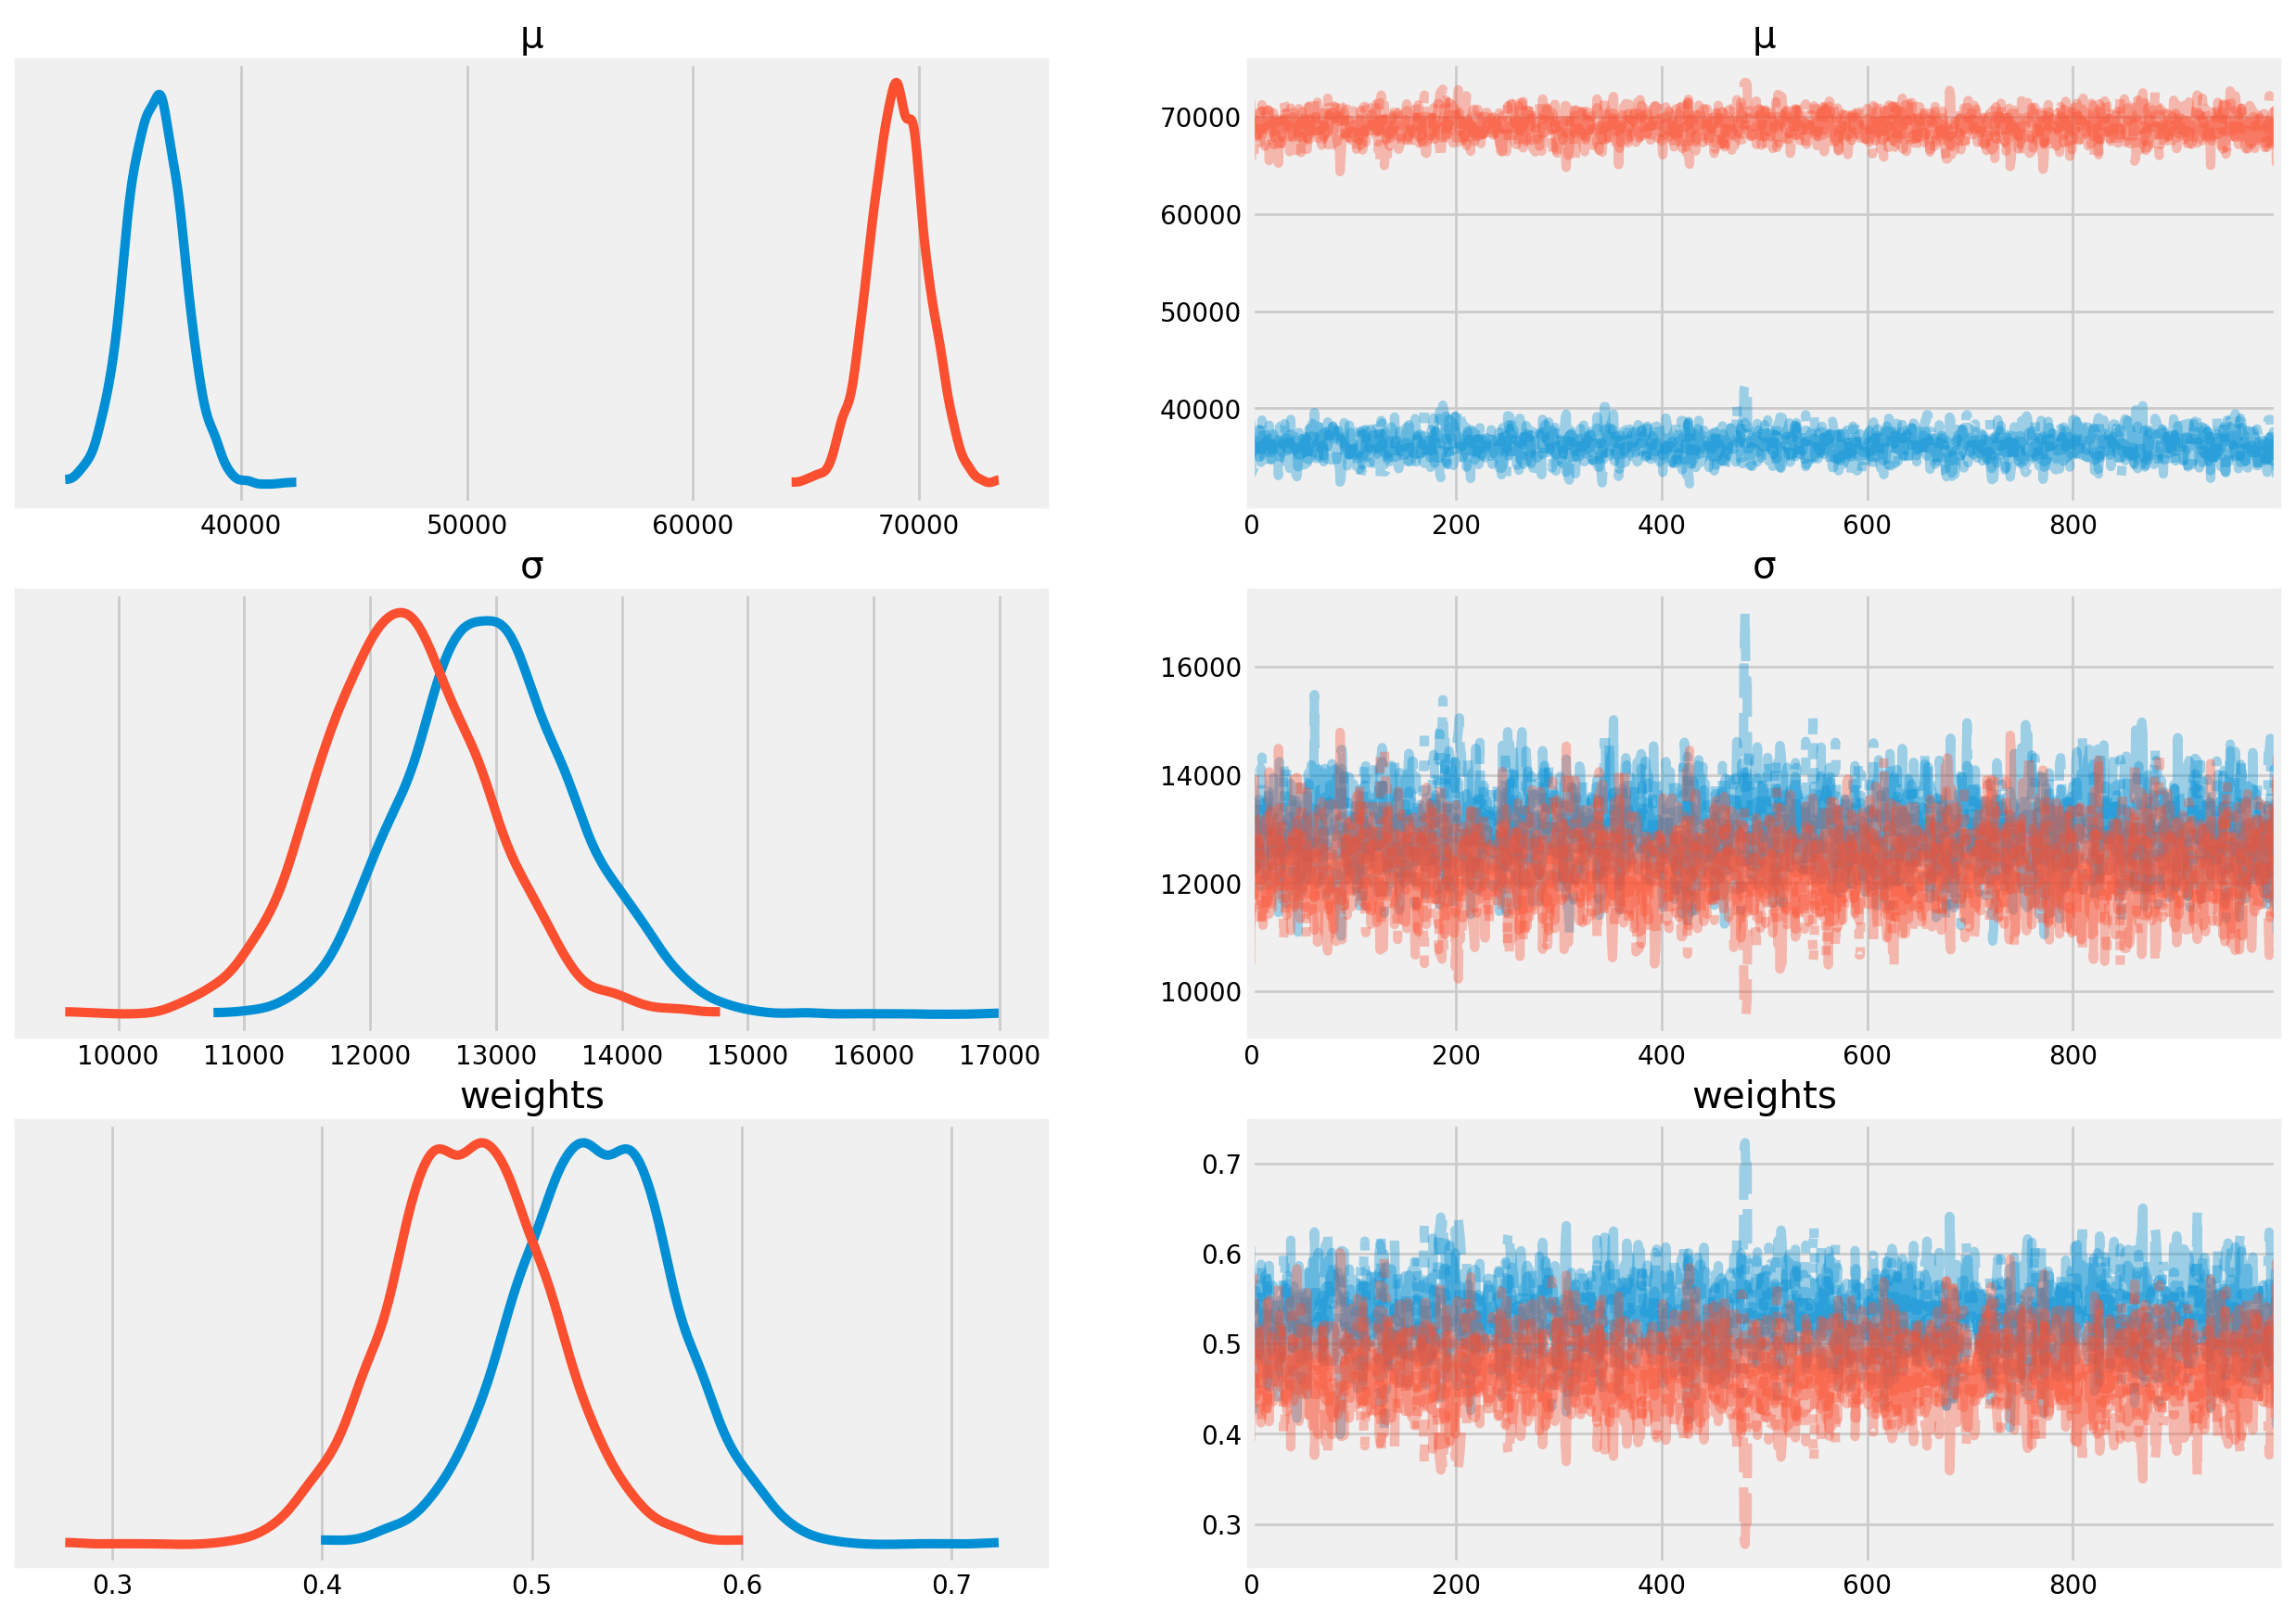

In [25]:
_ = az.plot_trace(income_gauss_trace, kind='trace', combined=True, figsize=(14, 10))

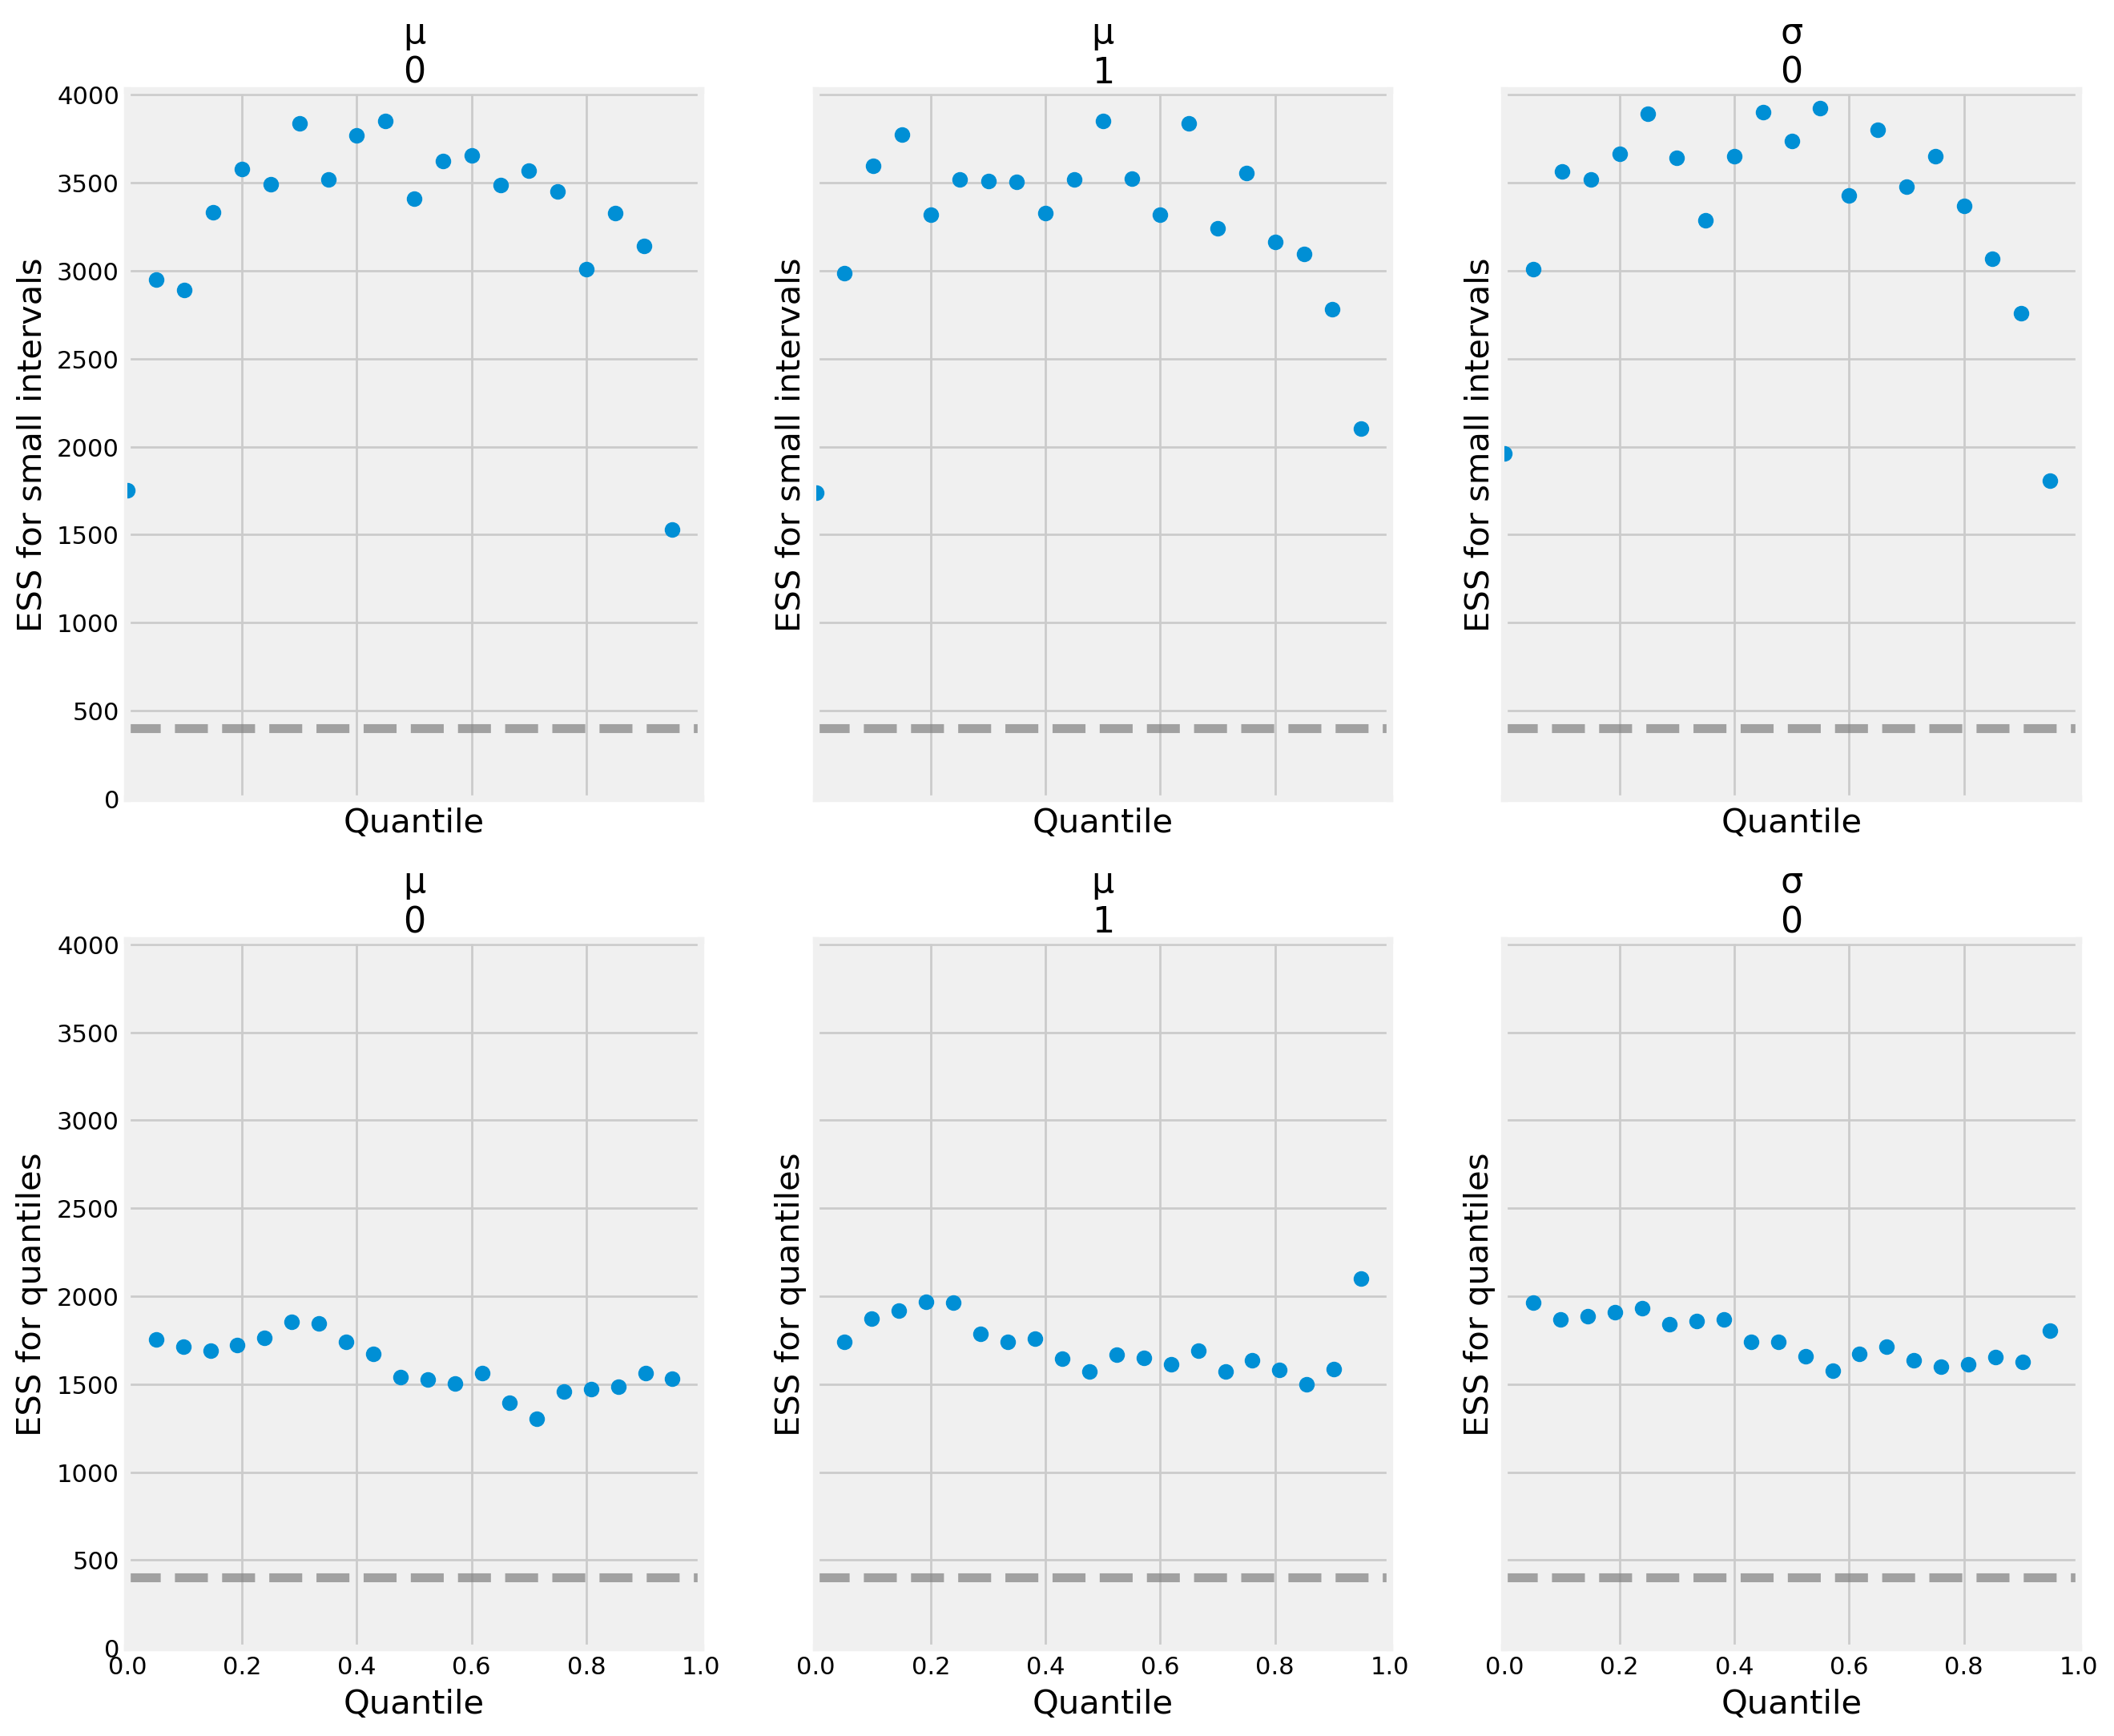

In [28]:
_, axes = plt.subplots(2, 3, sharey=True, sharex=True, figsize=(14, 12))
az.plot_ess(income_gauss_trace, kind="local", ax=axes[0]);
az.plot_ess(income_gauss_trace, kind="quantile", ax=axes[1]);

Great! We can see from local